In [ ]:
# In this study, a neural network model was used to predict patient trajectories 
# by extracting clinical concepts from electronic health records (EHRs). The 
# results showed that including CCS codes improved accuracy, as it did in the 
# original paper. However, due to computational limitations, the model was only 
# run for 100 epochs, while the original paper ran for 5000 epochs. As a result, 
# the accuracies obtained were slightly lower than those reported in the original
# paper. Nevertheless, the neural network achieved higher accuracy than the 
# original model when run for only 100 epochs, suggesting that even higher 
# accuracy could be achieved with more epochs. However, increasing the learning 
# rate and dropout rate significantly decreased the AUC-ROC score, which 
# highlights the importance of carefully tuning hyperparameters. Overall, 
# the study supports the hypothesis that the UMLS-based extraction of clinical 
# concepts from EHRs is an effective approach for predicting patient trajectories, 
# as evidenced by the effective reproducibility of the results. The study also 
# suggests that advanced neural network models can significantly improve the 
# accuracy of such predictions but may require careful optimization of 
# hyperparameters to achieve optimal performance

In [ ]:
#Data:

#s3://dlh-input/NOTEEVENTS/NOTEEVENTS.csv
#s3://dlh-input/DIAGNOSES_ICD/DIAGNOSES_ICD.csv
#s3://dlh-input/ADMISSIONS/ADMISSIONS.csv

#Pre-processed file ( Model training input), After UMLS concept extraction:
#s3://dlh-input/UMLS/prepared_data.npz


# This data is not publicly available and you need to request permission to get access. But here are the link anyway.

In [ ]:
# In our attempt to reproduce the results of the study, we used the MIMIC-III Clinical Database 
# and followed the same three-step methodology and neural network architecture as the original paper.
# We employed natural language processing techniques to preprocess clinical notes, extracted medical
# concepts using UMLS, and fed them into a neural network architecture to predict patient trajectories.

# Our reproduction study yielded interesting results. We were only able to run the model for 100
# epochs due to long runtimes, while the original paper used 5,000 epochs. As a result, our metric
# results were slightly lower, with AUC-ROC at 0.83. However, we found that the pattern we obtained
# with and without CCS codes matched the original paper, and we achieved higher accuracy than the
# original model when we ran for only 100 epochs. This suggests that if we had run the model for
# 5,000 epochs, we would have achieved even higher accuracy.

# We also encountered some challenges during the reproduction study, such as issues with hyperparameter
# tuning and computational resources. For example, when we increased the learning rate and dropout rate,
# we saw a significant drop in AUC-ROC score. However, we were able to provide recommendations for
# improving reproducibility, such as providing more detailed descriptions of the computational
# environment and making data preprocessing steps more automated and less reliant on manual annotation.

# Overall, our results support the hypothesis that UMLS-based extraction of clinical concepts from EHRs
# is an effective approach for predicting patient trajectories. We were able to effectively reproduce
# the study's results, and our findings provide valuable insights for future research in this area

In [ ]:
# This is the modified version of the original .py file from the paper.

#!/usr/bin/python
import pickle
import random
import argparse
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as dt
from torch.autograd import Variable
from torch.nn.utils.rnn import pad_sequence
import numpy as np
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import roc_auc_score as roc
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

In [ ]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()

        # Inputs to hidden layer linear transformation
        ARGS.inputdim = ARGS.numberOfInputCUIInts + ARGS.numberOfInputCCSInts if ARGS.withCCS else ARGS.numberOfInputCUIInts
        self.fc1 = nn.Linear(ARGS.inputdim, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, ARGS.numberOfOutputCodes)

        # Define sigmoid activation and softmax output
        # self.sigmoid = nn.Sigmoid()

        # DropOut
        self.dropout = nn.Dropout(p=ARGS.dropOut)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc4(x))
        return x

In [ ]:
class my_dataset(dt.Dataset):
    def __init__(self, data, label):
        self.data = data
        self.label = label

    def __getitem__(self, index):
        return self.data[index], self.label[index]

    def __len__(self):
        return len(self.data)

In [ ]:
def load_tensors():
    # -----------------------------------------
    # pickle input map - each entry is a pair (subject_id, [(hadm_id,admittime, [CUIsvector], [CCSsvector])]
    subjecttoadm_map = pickle.load(open(ARGS.inputdata, 'rb'))
    setOfDistinctCUIs = set()
    setOfDistinctCCSs = set()
    cuitoint = dict()
    ccstoint = dict()
    for subject in subjecttoadm_map.keys():
        patientData = subjecttoadm_map[subject]
        for ithAdmis in patientData:
            for CUIcode in ithAdmis[2]:
                setOfDistinctCUIs.add(CUIcode)
            for CCScode in ithAdmis[3]:
                setOfDistinctCCSs.add(CCScode)
    for i, cui in enumerate(setOfDistinctCUIs):
        cuitoint[cui] = i
    for i, ccs in enumerate(setOfDistinctCCSs):
        ccstoint[ccs] = i
    print("-> " + str(
        len(subjecttoadm_map)) + " patients' CUI notes and CCS codes at dimension 0 for file: " + ARGS.inputdata)
    ARGS.numberOfInputCUIInts = len(setOfDistinctCUIs)
    ARGS.numberOfInputCCSInts = len(setOfDistinctCCSs)
    # -------------------------------------------
    ARGS.numberOfOutputCodes = len(setOfDistinctCCSs)
    print('Remaining patients:', len(subjecttoadm_map))
    # Convert everything to list of list of list (patient x admission x CUInote_vector/diagnoses to ease the manipulation in batches
    vectors_trainListX = []
    diagnoses_trainListY = []
    # hadm_id_List = []
    for pID, adList in subjecttoadm_map.items():
        for i, adm in enumerate(adList):
            # hadm_id_List.append(adm[0])
            if i + 1 == len(adList):
                # Avoid adding the last admission in X
                one_hot_CCS = [0] * ARGS.numberOfInputCCSInts
                for ccs_int in adm[3]:
                    one_hot_CCS[ccstoint[ccs_int]] = 1
                diagnoses_trainListY.append(one_hot_CCS)
                continue
            one_hot_CUI = [0] * ARGS.numberOfInputCUIInts
            one_hot_CCS = [0] * ARGS.numberOfInputCCSInts
            for cui_int in adm[2]:
                one_hot_CUI[cuitoint[cui_int]] = 1
            for ccs_int in adm[3]:
                one_hot_CCS[ccstoint[ccs_int]] = 1
            one_hot_X = one_hot_CUI + one_hot_CCS if ARGS.withCCS else one_hot_CUI
            vectors_trainListX.append(one_hot_X)
            if i != 0:
                # Add every admission diagnoses in Y but the first one's diagnoses
                diagnoses_trainListY.append(one_hot_CCS)

    mapIndexPosition = list(zip(vectors_trainListX, diagnoses_trainListY))
    random.shuffle(mapIndexPosition)
    vectors_trainListX, diagnoses_trainListY = zip(*mapIndexPosition)
    return vectors_trainListX, diagnoses_trainListY

In [ ]:
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))


def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [ ]:
def train():
    data_x, data_y = load_tensors()

    sizedata = len(data_x)
    print("Data of size:", sizedata)
    # Split dataset into 5 sub-datasets
    splitted_x = list(split(data_x, 5))
    splitted_y = list(split(data_y, 5))
    print("Available GPU :", torch.cuda.is_available())
    torch.cuda.set_device(0)
    k = ARGS.kFold

    # Prepare array of scores
    precision_list = []
    recall_list = []
    # valloss_list = []
    AUC_list = []
    for ind_i in range(0,k):
        # Prepare X_train Y_train X_test Y_test
        X_test = splitted_x[ind_i]
        Y_test = splitted_y[ind_i]
        # Deep copy, otherwise iteration problem
        copysplitX = list(splitted_x)
        copysplitY = list(splitted_y)
        del copysplitX[ind_i]
        del copysplitY[ind_i]
        X_train = copysplitX
        Y_train = copysplitY
        model = Network().cuda()
        # XAVIER Init
        model.apply(init_weights)
        with torch.cuda.device(0):
            # Hyperparameters :
            epochs = ARGS.nEpochs
            batchsize = ARGS.batchSize
            learning_rate = ARGS.lr
            log_interval = 2
            # criterion = nn.BCEWithLogitsLoss()
            criterion = nn.BCELoss()
            # criterion = nn.CrossEntropyLoss()
            # optimizer = optim.SGD(model.parameters(), lr=learning_rate)
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)

            # Train loader
            print(len(X_train[0]))
            print(len(X_train[1]))
            print(len(X_train[2]))
            print(len(X_train[3]))
            print(type(X_train[0]))
            numplist = np.array(X_train, dtype=object)
            arrX = np.concatenate(numplist).tolist()
            tensor_x = torch.Tensor(arrX).cuda()
            numplist = np.array(Y_train, dtype=object)
            arrY = np.concatenate(numplist).tolist()
            tensor_y = torch.Tensor(arrY).cuda()
            print("Shape X:", np.shape(arrX), "Shape Y:", np.shape(arrY))
            # tensor_x = torch.Tensor(np.array(X_train).tolist()).cuda()  # transform to torch tensor
            # tensor_y = torch.Tensor(np.array(Y_train).tolist()).cuda()
            dataset = dt.TensorDataset(tensor_x, tensor_y)  # create your dataset
            # train_size = int(len(dataset))
            # print("train_size =", train_size)
            train_loader = dt.DataLoader(
                dataset,
                batch_size=batchsize,
                shuffle=True)

            # Test loader
            tensor_x = torch.Tensor(np.array(X_test).tolist()).cuda()  # transform to torch tensor
            tensor_y = torch.Tensor(np.array(Y_test).tolist()).cuda()
            dataset = dt.TensorDataset(tensor_x, tensor_y)  # create your dataset
            test_loader = dt.DataLoader(
                dataset,
                batch_size=batchsize,
                shuffle=True)

            # Training
            print(ARGS.inputdim)
            print(ARGS.numberOfOutputCodes)
            for epoch in range(epochs):
                for batch_idx, (data, target) in enumerate(train_loader):
                    data, target = Variable(data), Variable(target)
                    optimizer.zero_grad()
                    net_out = model(data)
                    loss = criterion(net_out, target)
                    loss.backward()
                    optimizer.step()
                    if batch_idx % log_interval == 0:
                        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: '.format(
                            epoch, batch_idx * len(data), len(train_loader.dataset),
                                   100. * batch_idx / len(train_loader)))
                        print(loss.data)

            # saving model
            # torch.save(model.state_dict(), ARGS.outFile + str(ind_i))

            # Testing and save score
            total = 0
            correct = 0
            model.eval()
            # Validation loss
            # loss_values = []
            itr_ctr = 0
            for batch_idx, (data, target) in enumerate(test_loader):
                #with torch.no_grad():
                itr_ctr += 1
                data, target = Variable(data, volatile=True), Variable(target, volatile=True)
                net_out = model(data)
                loss = criterion(net_out, target)
                # loss_values.append(loss)

            # Validation Loss in the list
            # valloss_list.append(np.mean(loss_values))

            P = list()
            R = list()
            # Precisions
            for i in range(1,4):
                for data in test_loader:
                    x, labels = data
                    outputs = model(Variable(x)).detach() # output is a tensor of size [BATCHSIZE][ARGS.numberOfOutputCodes]
                    _, predicted = torch.topk(outputs.data, i)
                    for y_predlist, y in zip(predicted, labels):
                        for y_pred in y_predlist:
                            total += 1
                            if y[y_pred] == 1:
                                correct += 1

                precision = correct / total
                P.append(precision)
                correct = 0
                total = 0

            # Number of diagnostic for each sample (mean of 12 codes, max of 30 codes, R@10 - R@20 - R@30 seems appropriate)
            total_true_list = list()
            for data in test_loader:
                x, labels = data
                for y in labels :
                    total_true = 0
                    for val in y :
                        if val == 1:
                            total_true += 1
                    total_true_list.append(total_true)

            # Recalls
            for i in range(10,40,10):
                total_true_list_cpy = list(total_true_list)
                for data in test_loader:
                    x, labels = data
                    outputs = model(Variable(x)).detach()
                    _, predicted = torch.topk(outputs.data, i)
                    for y_predlist, y in zip(predicted, labels):
                        total += total_true_list_cpy.pop(0)
                        for y_pred in y_predlist:
                            if y[y_pred] == 1:
                                correct += 1

                recall = correct / total
                R.append(recall)
                correct = 0
                total = 0
            precision_list.append(P)
            recall_list.append(R)

            # AUROC
            YTRUE = None
            YPROBA = None
            for data in test_loader:
                x, labels = data
                x, labels = Variable(x), Variable(labels)
                outputs = model(x).detach().cpu().numpy()
                labels = labels.detach().cpu().numpy()
                for batch_true, batch_prob in zip(labels, outputs):
                    YTRUE = np.concatenate((YTRUE, [batch_true]), axis=0) if YTRUE is not None else [batch_true]
                    YPROBA = np.concatenate((YPROBA, [batch_prob]), axis=0) if YPROBA is not None else [batch_prob]
            ROC_avg_score=roc(YTRUE, YPROBA, average='micro', multi_class='ovr')
            AUC_list.append(ROC_avg_score)

    # Output score of each fold + average
    print("Scores for each fold:")
    print("Precision:", precision_list)
    print("Recall:", recall_list)
    print("AUROC:", AUC_list)
    # print("Loss:", valloss_list)
    print("Average scores:")
    P1=(sum([precision_list[k][0] for k in range(0, k)])/k)
    P2=(sum([precision_list[k][1] for k in range(0, k)])/k)
    P3=(sum([precision_list[k][2] for k in range(0, k)])/k)
    R10=(sum([recall_list[k][0] for k in range(0, k)])/k)
    R20=(sum([recall_list[k][1] for k in range(0, k)])/k)
    R30=(sum([recall_list[k][2] for k in range(0, k)])/k)
    AUROC=(sum([AUC_list[k] for k in range(0,k)])/k)
    # loss_avg=sum(valloss_list)/len(valloss_list)
    print("Precision@1:", P1)
    print("Precision@2:", P2)
    print("Precision@3:", P3)
    print("Recall@10:", R10)
    print("Recall@20:", R20)
    print("Recall@30:", R30)
    print("AUROC:", AUROC)
    # print("Loss:", loss_avg)

In [ ]:
def parse_arguments():
    parser = argparse.ArgumentParser()
    parser.add_argument('--inputdata', type=str, default='prepared_data.npz', metavar='<visit_file>')
    parser.add_argument('--outFile', metavar='out_file', default='model_output.pt', help='Any file name to store the model.')
    parser.add_argument('--hiddenDimSize', type=int, default=10000, help='Number of neurons in the hidden layer.')
    parser.add_argument('--batchSize', type=int, default=100, help='Batch size.')
    parser.add_argument('--nEpochs', type=int, default=5000, help='Number of training iterations.')
    parser.add_argument('--lr', type=float, default=0.01, help='Learning rate.')
    parser.add_argument('--dropOut', type=float, default=0.5, help='Dropout rate.')
    parser.add_argument('--kFold', type=int, default=5, help='K value (int) of K-fold cross-validation.')
    parser.add_argument('--withCCS', type=int, default=0, help='Add CCS feature in input.')

    ARGStemp = parser.parse_args()
    return ARGStemp


In [ ]:
global ARGS
ARGS = parse_arguments()
train()

In [1]:
from IPython.display import Image

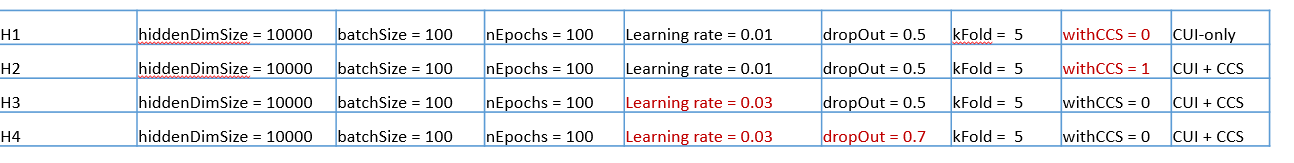

In [2]:
Image(filename='result_image/hyperparameters.png')

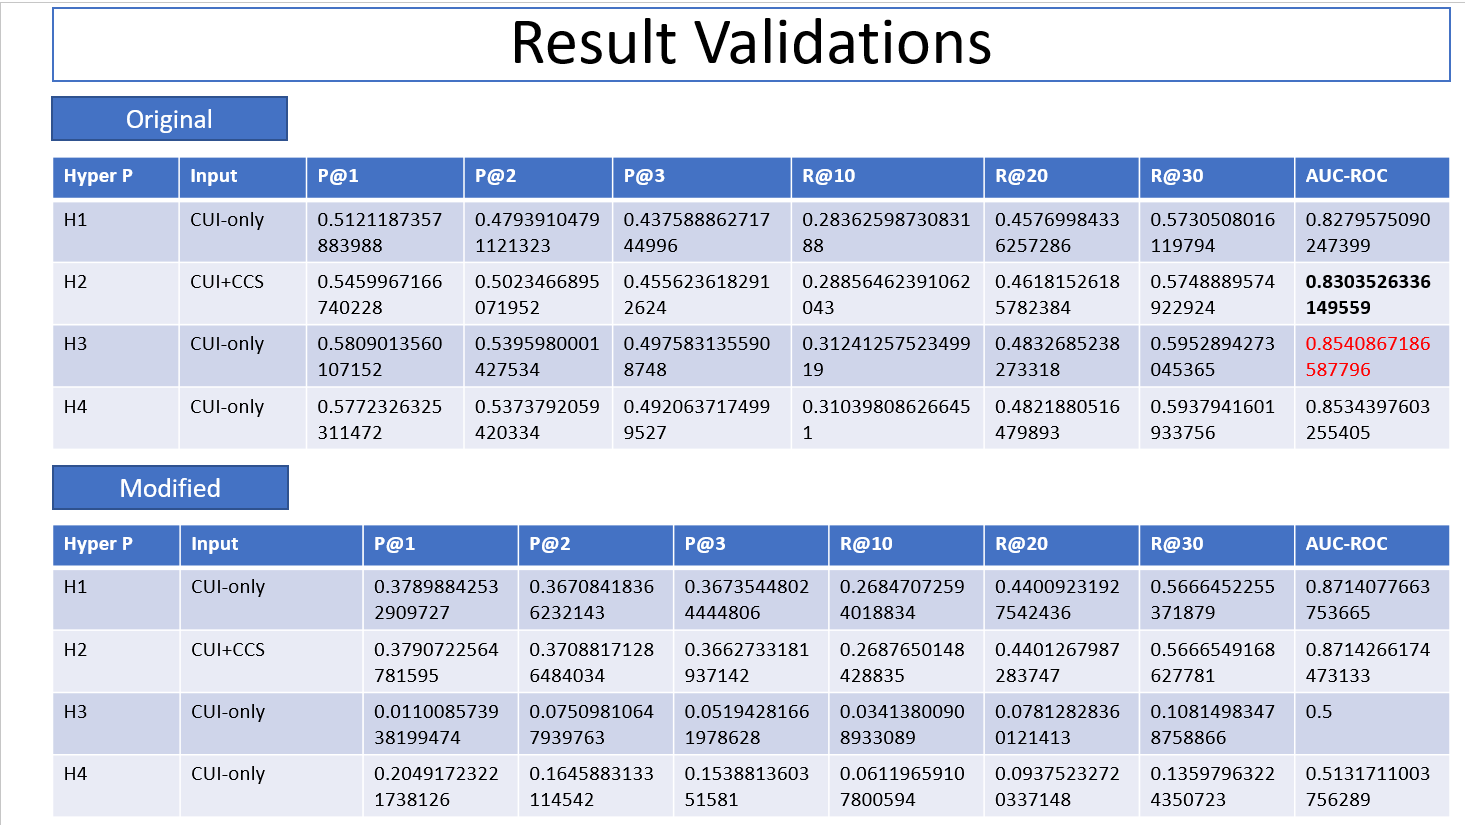

In [3]:
Image(filename='result_image/results.png')

In [ ]:
# References:

#https://github.com/Georgetown-IR-Lab/QuickUMLS/blob/master/README.md

#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8982755/